In [4]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from numpy import conj,argmax
from scipy import signal

In [5]:
# Set the log file path
logFileName = 'delay'
logFileType = '.BBL'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

# Create decode command
decodeCommand = decodePath + ' ' + logFilePath
#print(cmd)

In [6]:

# Decode
os.system(decodeCommand)

# blackbox_decode will create a .event file, we don't need that
junkFile = logFileName+'.01.event'
os.remove(junkFile)



In [7]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) 
#df.head()
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
#print(time[0])
time=time-time[0]
#print(time)
diffOfTime = np.diff(time)
#print(diffOfTime)
averageUs = np.median(diffOfTime)
#print(averageUs)
samplingRate = 1000000/averageUs
print(samplingRate)

2000.0


In [8]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]
#print(setpointData)
#print(gyroADCData)
#print(gyroScaleData)
print(thrData)

[1000 1000 1000 ... 1244 1244 1244]


In [26]:
def calculateDelay(a,b):
    
    a_fft    = fft(np.hamming(len(a)) *a)   #a must be later than b
    #a_fft    = fft(a)
    b_fft    = fft(np.hamming(len(b)) *b)   #hamming for now, maybe hanning is better?
    #b_fft    = fft(b)
    c       = ifft(a_fft*conj(b_fft))
    time_shift  = argmax(abs(c))
    #plt.plot(c)
    return time_shift

inputSignal = gyroScaleData[0]
outputSignal = gyroADCData[0]

overall_delay = calculateDelay(outputSignal,inputSignal)
print(overall_delay)

8


In [27]:
# modify this cell to calculate delay
def inter(x):
    tmp_a = np.arange(0,len(x),1)
    tmp_b = interpolate.interp1d(tmp_a,x)
    y = tmp_b(np.arange(0,len(x)-10,0.1))
    return y

thr = thrData #1000~2000
bufferSize = 256
batch = int(len(inputSignal)/(bufferSize/2))
thrDelay = np.zeros(100, dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)

for i in range(0, len(inputSignal)-bufferSize, 10):
    idx = i
    avgThr = int(np.sum(thr[idx:idx+bufferSize])/bufferSize/10) - 100
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    intered_input = inter(inputSignal[idx:idx+bufferSize])
    intered_output = inter(outputSignal[idx:idx+bufferSize])
    # Up sampling to increase precision

    tmpDelay = calculateDelay(intered_output,intered_input)

    if tmpDelay > 20*overall_delay:
        continue

    delay = tmpDelay/(int(samplingRate/100))
    thrDelay[avgThr] = thrDelay[avgThr]+delay
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thrDelay[i]=thrDelay[i]/thrCount[i]

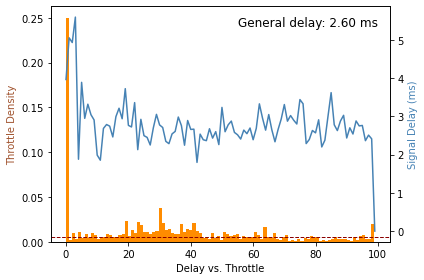

In [44]:
thrOffData = (thrData/10)-100
x = thrOffData

num_bins = 100
general_delay = np.sum(thrDelay[20:45]) / 25

fig, ax1 = plt.subplots()
n, bins, patches = ax1.hist(x, num_bins, density=True, color="darkorange")
ax1.set_xlabel('Delay vs. Throttle')
ax1.set_ylabel('Throttle Density', color="sienna")
plt.axhline(0.005 , color='darkred', linewidth=1, linestyle='--')

plt.text(100, 0.24, "General delay: %.2f ms"  %general_delay, size= 'large', ha='right')

ax2 = ax1.twinx()
ax2.set_ylabel('Signal Delay (ms)', color='steelblue')  # we already handled the x-label with ax1
ax2.plot(thrDelay, color='steelblue')
ax2.tick_params(axis='y')


fig.tight_layout()
plt.show()

In [36]:

print(general_delay, precision)